# Findings

- Though this is not proven to be converged, we see here that there are differences in the additive approach, just only visible on much tighter axes. 
- For small $\omega_0$ (though $\approx \eta$), the Redfield approach seems to predict very little effect on the overall populations and coherences
- The Additive collective coordinate approach leads to greater excitation of the bright state than the non-additive. Non-additive has more pronounced redistribution among GS and DS.
- Amazingly, the additive and non-additive predict exactly the same exciton coherence. This is baffling and will need to be examined a lot further.
- One issue is that we are dealing with system splittings which are an order of magnitude larger than this, but the same incoherent excitation temperature. This also goes to couplings of about 5% of the splitting, whereas my other plots only go to about 1% of the splitting.
- I also use a $k_{B_{ph}} \approx 2 \omega_0$, which is quite a bit larger than in the results with optical parameters, where $k_{B_{ph}} \approx \omega_0$ and these plots have terrible resolution.
- In this regime, the weak-coupling theory is totally invalid
- We would expect the additive theory to break down in regimes where the phonon frequency is low, as this is where the displacements are larger. 
- Additivity works well at low temperatures, the change observables wrt $\alpha$ is far more sensitive than the due to changes in additivity. Even weak-coupling theory works quite well at low-T (though not for very low frequencies).

# Explanations

The low temperature means that the population stays in the lower eigenstates in the manifold and there is relatively little upward transition. This causes the phonon transition rates to dominate over the optical transition rates. When $T_{ph}$ is larger, the population stays higher in the manifold and that nature of the optical transitions is exhibited more.

In [66]:
Occupation(11000., 6000.)

0.07701986980267503

In [1]:
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt

import time
import heatmap_setup as hm
import numpy as np

from SES_setup import *
from utils import *
from style import *

SES_setup loaded globally


In [2]:
def get_dynamics_data(PARAMS, data_num, threshold=0., tf=2.):
    #print PARAMS['H_sub'].eigenstates()
    ti = time.time()
    
    H_wc, L_ns, L_s = get_H_and_L_wc(PARAMS['H_sub'], PARAMS, secular_phonon=True)
    H, L, L_add, PARAMS = get_H_and_L(PARAMS, silent=False, threshold=threshold)
    
    evals, evecs = exciton_states(PARAMS, shift=False)
    dark, bright = evecs[0]*evecs[0].dag(), evecs[1]*evecs[1].dag()
    eig_x = (evecs[0]*evecs[1].dag() + evecs[1]*evecs[0].dag())*0.5
    site_x = (site_coherence+site_coherence.dag())
    site_y = 1j*(site_coherence-site_coherence.dag())
    ops = make_expectation_operators(PARAMS)
    eig_y = 1j*(evecs[0]*evecs[1].dag() - evecs[1]*evecs[0].dag())*0.5
    
    # 1 is weak coupling, room temperature, low freq
    timelist = np.linspace(0, tf, tf*1000)

    init_sys = XO_proj
    v0 = tensor(init_sys, qt.enr_thermal_dm([PARAMS['N_1'], PARAMS['N_2']], PARAMS['exc'], Occupation(PARAMS['w0_1'], PARAMS['T_1'])))
    e_ops=[ops['OO'], ops['dark'], ops['bright'], ops['XO'], ops['OX'], ops['sigma_x'], ops['eig_x'], ops['sigma_y'], ops['eig_y']]
    e_ops_wc=[OO_proj, dark, bright, XO_proj, OX_proj, site_x, eig_x, site_y, eig_y]
    
    if PARAMS['sys_dim'] ==4:
        e_ops+=ops['XX']
        e_ops_wc+= XX_proj
    print("Liouvillians took {} seconds".format(time.time()-ti))
    
    ss_wcs = steadystate(PARAMS['H_sub'], [L_s])
    ss_wc = steadystate(PARAMS['H_sub'], [L_ns])
    #ss_add = steadystate(H[1], [L_add])
    ss_nonadd = steadystate(H[1], [L])
    print((ss_wcs*OO_proj).tr().real, (ss_wc*OO_proj).tr().real, (ss_nonadd*ops['OO']).tr().real)
    print((ss_wcs*eig_x).tr().real, (ss_wc*eig_x).tr().real, (ss_nonadd*ops['eig_x']).tr().real)
    
    options = qt.Options(nsteps=20000)
    dat_wcs = qt.mesolve(PARAMS['H_sub'], init_sys, timelist, c_ops=[L_s], 
                      e_ops=e_ops_wc, options=options) # weak coupling
    dat_wc = qt.mesolve(PARAMS['H_sub'], init_sys, timelist, c_ops=[L_ns], 
                      e_ops=e_ops_wc, options=options) # weak coupling
    #dat_add = qt.mesolve(H[1], v0, timelist, c_ops=[L_add], 
    #                  e_ops=e_ops, progress_bar=True, options=options)
    dat_nonadd = qt.mesolve(H[1], v0, timelist, c_ops=[L], 
                      e_ops=e_ops, progress_bar=True, options=options)
    
    data_dict = {}
    #filename = 'DATA/DYNAMICS_2019/3LS_dynamics_'+str(data_num)
    PARAM_names = ['dat_nonadd', 'dat_wcs', 'dat_wc', 
                   'PARAMS', 'ss_nonadd', 'ss_wcs', 'ss_wc','timelist']
    scope = locals() # Lets eval below use local variables, not global
    data_dict.update(dict((name, eval(name, scope)) for name in PARAM_names))
    try:
        pass
        #save_obj(data_dict, filename)
        #print( "Filename: "+filename)
    except Exception as e:
        print( "Could not save data because ", e)
    return data_dict


In [3]:
def plot_dynamics(data_dict):
    
    # code goes here to take in and plot dynamics for wc, add and non-add
    tl =data_dict['timelist']
    labels = ['Secular', 'Non-secular', 'Non-add.']
    f, ((ax1, ax2),(ax3, ax4))  = plt.subplots(2, 2, sharex=True, figsize=(14,8))
    for i, suff in enumerate(['_wcs', '_wc', '_nonadd']):
        alpha=1
        ls='solid'
        if i>0:
            alpha=0.5
            #ls='dotted'
        #GS pop
        ax1.plot(tl, data_dict['dat'+suff].expect[0], label=labels[i], alpha=alpha, ls=ls)
        ax1.set_ylabel(r"GS")
        ax1.set_xlim(tl[0], tl[-1])
        ax1.legend()
        #DS pop
        ax2.plot(tl, data_dict['dat'+suff].expect[1], label=labels[i], alpha=alpha, ls=ls)
        ax2.set_xlim(tl[0], tl[-1])
        ax2.set_ylabel(r"DS")
        ax2.legend()
        
        ax3.plot(tl, data_dict['dat'+suff].expect[2], label=labels[i], alpha=alpha, ls=ls)
        ax3.set_xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
        ax3.set_ylabel(r"BS")
        ax3.set_xlim(tl[0], tl[-1])
        ax3.legend()
        
        ax4.plot(tl, data_dict['dat'+suff].expect[6], label=labels[i], alpha=alpha, ls=ls)
        ax4.set_xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
        ax4.set_ylabel(r"$\Re \expval{|+\langle\!\rangle -|}$")
        ax4.set_xlim(tl[0], tl[-1])
        ax4.legend()
        


# Low $\omega_0$

$\alpha = 1, 10, 50$

In [4]:
T_ph = 300.
w_2 = 5000. #1.4*ev_to_inv_cm
bias = 100. #0.01*ev_to_inv_cm #0.0000001*ev_to_inv_cm
V = 100. #0.01*ev_to_inv_cm #0.00001*ev_to_inv_cm
alpha = 1.
T_EM = 6000.
alpha_EM = 5.309e-3 # inv_ps_to_inv_cm *10^-3
N =4

In [5]:
#wc = 50.
w_0 = 100.
Gamma = 2*w_0

PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_1a = get_dynamics_data(PARAMS, '1a', threshold=0., tf=2.)


alpha = 10.
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_1b = get_dynamics_data(PARAMS, '1b', threshold=0., tf=2.)

alpha = 50.
N=6
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=alpha,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_1c = get_dynamics_data(PARAMS, '1c', threshold=0., tf=0.25)

****************************************************************
The operators took 0.7674920558929443 and have dimension 39.
Building the RC Liouvillian took 0.817 seconds.
It is 1521by1521. The full basis would be 2304by2304
It took  0.6612961292266846  seconds to build the Non-secular RWA Liouvillian
It took  0.25487804412841797  seconds to build the Non-secular RWA Liouvillian
Chopping reduced the sparsity from 9.209% to 9.209%
Liouvillians took 2.112636089324951 seconds
0.6322955922897936 0.6322940728662949 0.4895912141991953
-1.3877787807814457e-17 -3.6477050546768197e-10 -6.533942964137996e-05


/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


10.0%. Run time:   1.03s. Est. time left: 00:00:00:09
20.0%. Run time:   2.05s. Est. time left: 00:00:00:08
30.0%. Run time:   3.09s. Est. time left: 00:00:00:07
40.0%. Run time:   4.06s. Est. time left: 00:00:00:06
50.0%. Run time:   5.02s. Est. time left: 00:00:00:05
60.0%. Run time:   6.01s. Est. time left: 00:00:00:04
70.0%. Run time:   6.97s. Est. time left: 00:00:00:02
80.0%. Run time:   7.96s. Est. time left: 00:00:00:01
90.0%. Run time:   8.94s. Est. time left: 00:00:00:00
Total run time:   9.86s
****************************************************************
The operators took 0.7666029930114746 and have dimension 39.
Building the RC Liouvillian took 0.805 seconds.
It is 1521by1521. The full basis would be 2304by2304
It took  0.6684360504150391  seconds to build the Non-secular RWA Liouvillian
It took  0.25038886070251465  seconds to build the Non-secular RWA Liouvillian
Chopping reduced the sparsity from 9.272% to 9.272%
Liouvillians took 1.9672319889068604 seconds
0.6322969

In [32]:
1/11200

8.928571428571429e-05

/Users/admin/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


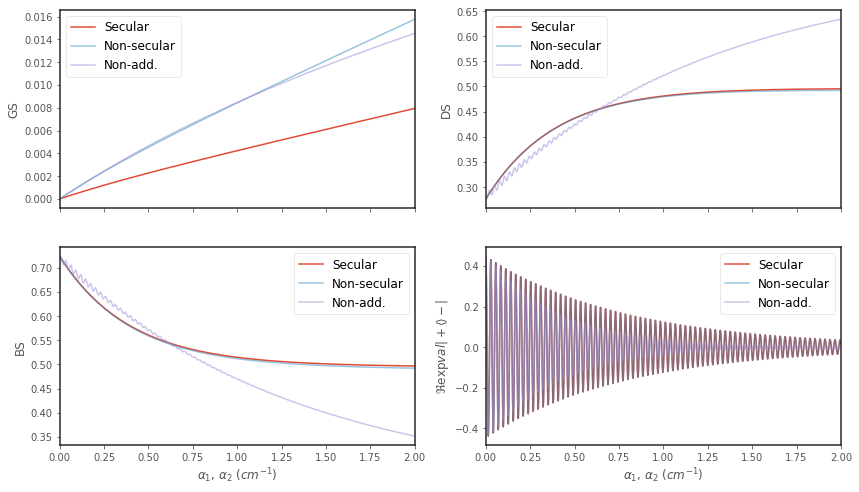

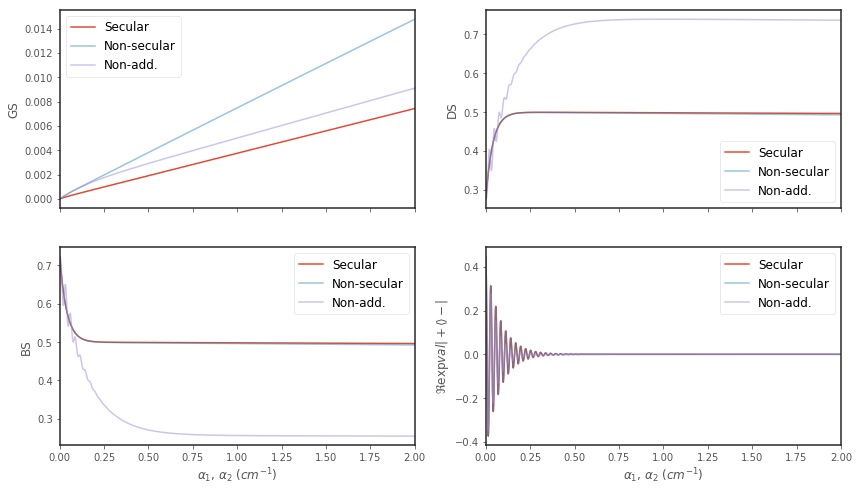

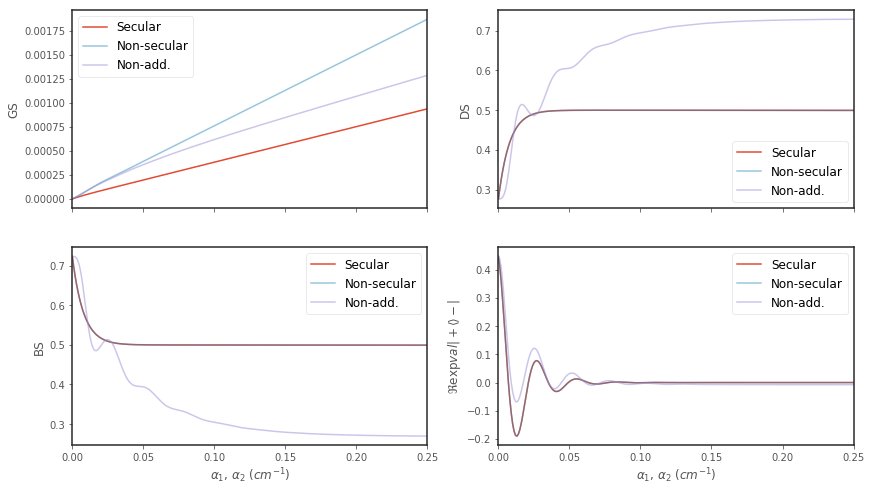

In [6]:
plot_dynamics(dynamics_1a)
plot_dynamics(dynamics_1b)
plot_dynamics(dynamics_1c)

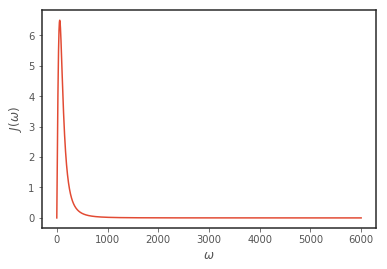

In [9]:
w_0 = 100.
Gamma = 2*w_0
alpha=10.

def plot_UD_SD(Gamma, alpha, w_0, eps=6000., ax=None):
    Omega = np.linspace(0,eps,10000)
    J_w = np.array([J_underdamped(w, alpha, w_0, Gamma=Gamma) for w in Omega])
    show_im = ax
    if ax is None:
        f, ax = plt.subplots(1,1)
    ax.plot(Omega, J_w)
    ax.set_xlabel(r"$\omega$")
    ax.set_ylabel(r"$J(\omega)$")
    if show_im is None:
        plt.show()
plot_UD_SD(Gamma, alpha, w_0, eps=6000., ax=None)

# larger $\omega_0$

In [38]:
w_0 = 500.
Gamma = 200.
N=5
T_ph = 300.
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=1.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_2a = get_dynamics_data(PARAMS, '2a', threshold=0., tf=2)

PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=10.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_2b = get_dynamics_data(PARAMS, '2b', threshold=0., tf=1)
N=6
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=50.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_2c = get_dynamics_data(PARAMS, '2c', threshold=0., tf=0.25)

****************************************************************
The operators took 1.5069420337677002 and have dimension 57.
Building the RC Liouvillian took 1.656 seconds.
It is 3249by3249. The full basis would be 5625by5625
It took  1.399543046951294  seconds to build the Non-secular RWA Liouvillian
It took  0.465167760848999  seconds to build the Non-secular RWA Liouvillian
Chopping reduced the sparsity from 6.549% to 6.549%
Liouvillians took 3.864802122116089 seconds
0.6322956936264853 0.6322942754496509 0.48954223961355753
0.0 -3.9068673296505096e-10 -0.00011245529796295014
10.0%. Run time:   1.99s. Est. time left: 00:00:00:17
20.0%. Run time:   4.03s. Est. time left: 00:00:00:16
30.0%. Run time:   6.02s. Est. time left: 00:00:00:14
40.0%. Run time:   8.03s. Est. time left: 00:00:00:12
50.0%. Run time:  10.06s. Est. time left: 00:00:00:10
60.0%. Run time:  12.10s. Est. time left: 00:00:00:08
70.0%. Run time:  14.10s. Est. time left: 00:00:00:06
80.0%. Run time:  16.09s. Est. time

/Users/admin/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


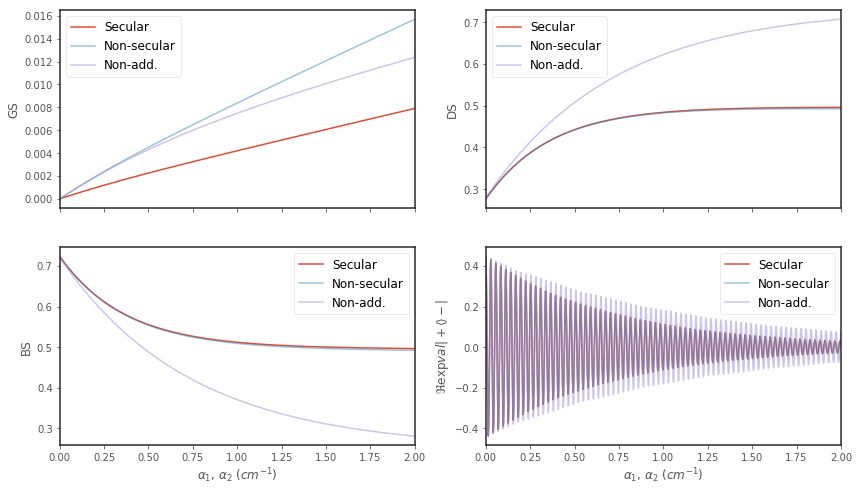

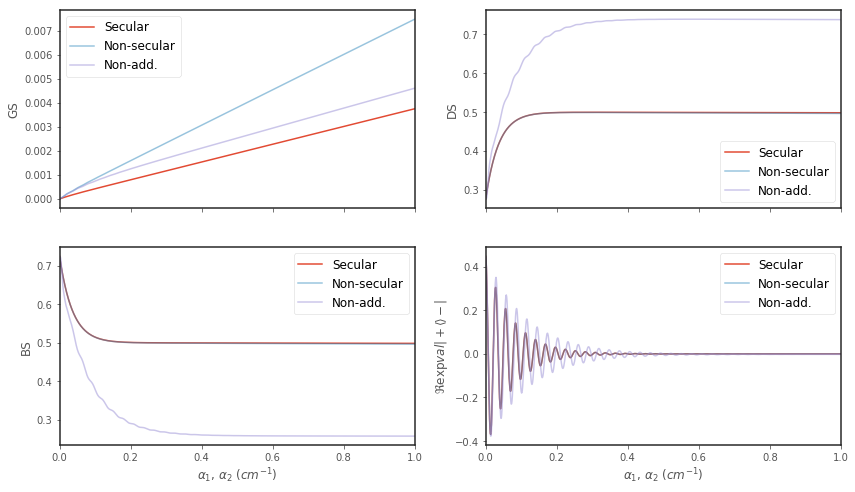

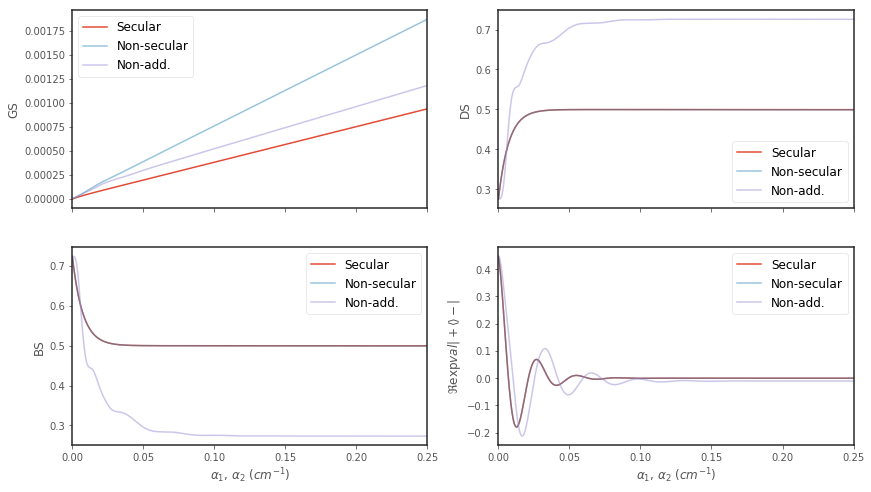

In [39]:
plot_dynamics(dynamics_2a)
plot_dynamics(dynamics_2b)
plot_dynamics(dynamics_2c)

# Low $T_{ph}$

In [49]:
w_0 = 100.
Gamma = 200.
N=5
T_ph = 77.
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=1.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_3a = get_dynamics_data(PARAMS, '3a', threshold=0., tf=4)

PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=10.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_3b = get_dynamics_data(PARAMS, '3b', threshold=0., tf=4)
N=6
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=50.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_3c = get_dynamics_data(PARAMS, '3c', threshold=0., tf=4)

****************************************************************
The operators took 1.6018929481506348 and have dimension 57.
Building the RC Liouvillian took 1.748 seconds.
It is 3249by3249. The full basis would be 5625by5625
It took  1.2996160984039307  seconds to build the Non-secular RWA Liouvillian
It took  0.4675769805908203  seconds to build the Non-secular RWA Liouvillian
Chopping reduced the sparsity from 6.518% to 6.518%
Liouvillians took 3.861220121383667 seconds
0.6322911004841787 0.6322851009094679 0.1816469036540866
0.0 -9.360710817585272e-11 -0.0011737691123330327
10.0%. Run time:   2.29s. Est. time left: 00:00:00:20
20.0%. Run time:   4.53s. Est. time left: 00:00:00:18
30.0%. Run time:   6.74s. Est. time left: 00:00:00:15
40.0%. Run time:   8.97s. Est. time left: 00:00:00:13
50.0%. Run time:  11.30s. Est. time left: 00:00:00:11
60.0%. Run time:  13.51s. Est. time left: 00:00:00:09
70.0%. Run time:  15.57s. Est. time left: 00:00:00:06
80.0%. Run time:  17.49s. Est. time 

/Users/admin/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


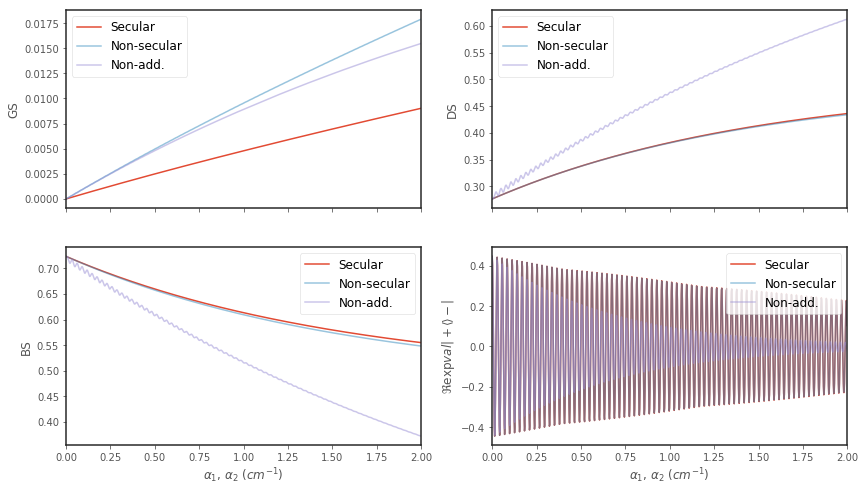

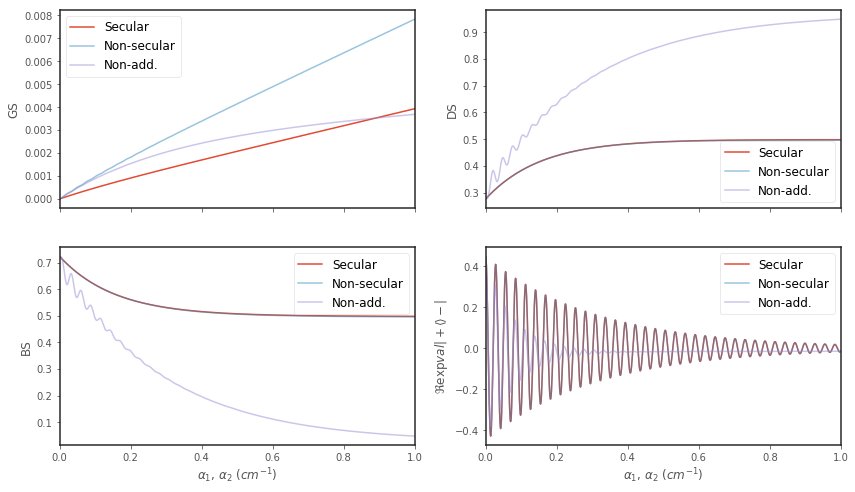

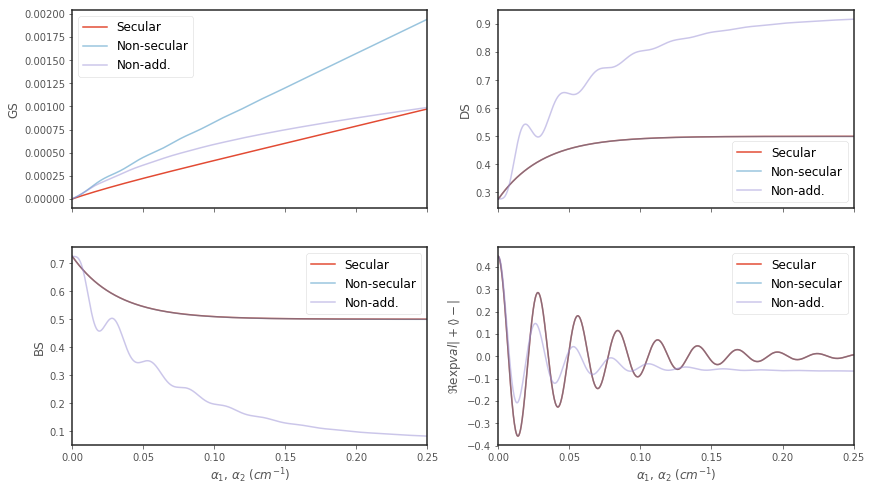

In [41]:
plot_dynamics(dynamics_3a)
plot_dynamics(dynamics_3b)
plot_dynamics(dynamics_3c)

In [42]:
w_0 = 5000.
Gamma = 200.
N=5
T_ph = 300.
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=1.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_4a = get_dynamics_data(PARAMS, '4a', threshold=1e-9, tf=2)

PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=10.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_4b = get_dynamics_data(PARAMS, '4b', threshold=1e-9, tf=1)

PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=50.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_4c = get_dynamics_data(PARAMS, '4c', threshold=1e-9, tf=0.25)

****************************************************************
The operators took 1.3860201835632324 and have dimension 57.
Building the RC Liouvillian took 1.547 seconds.
It is 3249by3249. The full basis would be 5625by5625
It took  0.8944060802459717  seconds to build the Non-secular RWA Liouvillian
It took  0.47081494331359863  seconds to build the Non-secular RWA Liouvillian
Chopping reduced the sparsity from 6.834% to 5.322%
Liouvillians took 3.2783122062683105 seconds
0.6320941825515121 0.6319051382974596 0.5124031581986397
1.3877787807814457e-17 -4.4106523988673985e-12 -2.364068579457193e-05
10.0%. Run time:  14.75s. Est. time left: 00:00:02:12
20.0%. Run time:  29.78s. Est. time left: 00:00:01:59
30.0%. Run time:  44.69s. Est. time left: 00:00:01:44
40.0%. Run time:  59.86s. Est. time left: 00:00:01:29
50.0%. Run time:  74.87s. Est. time left: 00:00:01:14
60.0%. Run time:  89.88s. Est. time left: 00:00:00:59
70.0%. Run time: 104.82s. Est. time left: 00:00:00:44
80.0%. Run tim

/Users/admin/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


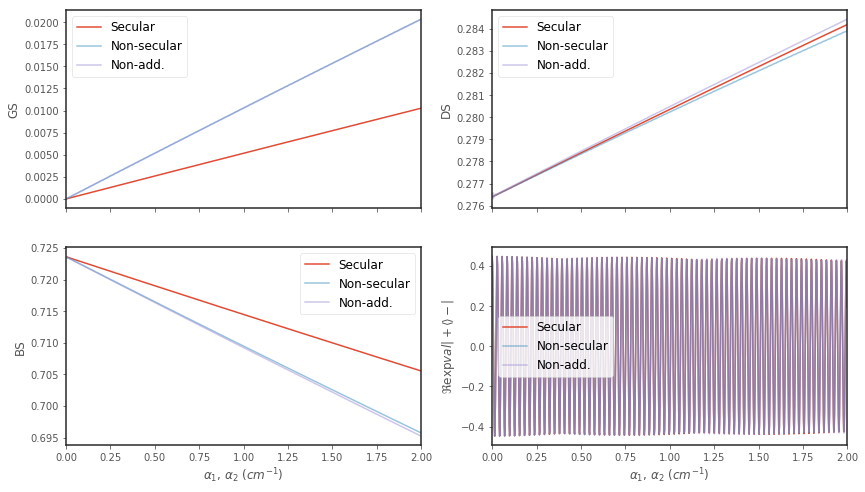

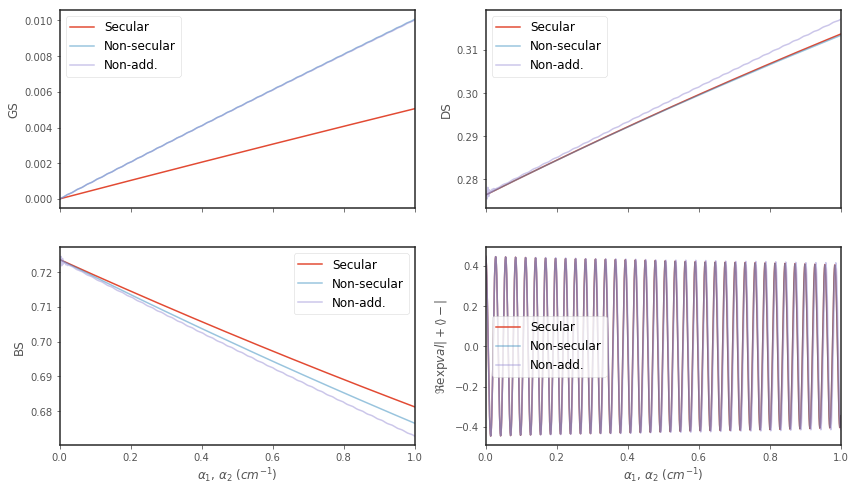

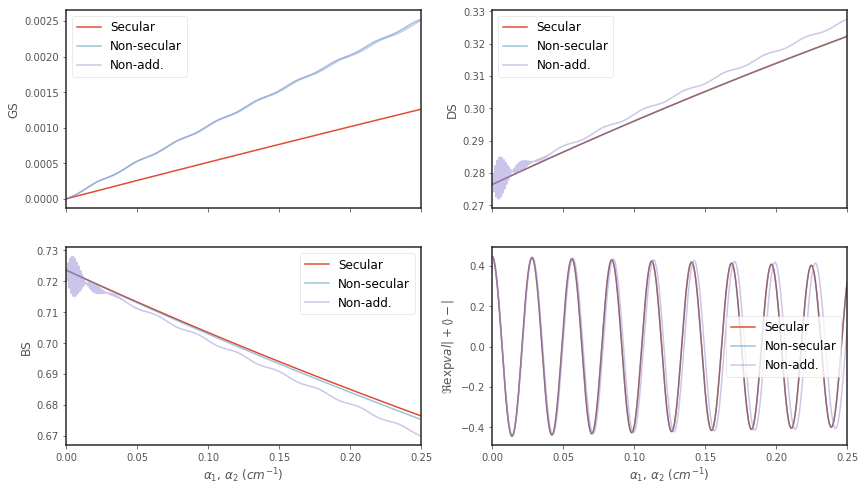

In [43]:
plot_dynamics(dynamics_4a)
plot_dynamics(dynamics_4b)
plot_dynamics(dynamics_4c)

In [44]:
w_0 = 3000. # 
Gamma = (w_0**2)/53.
N=4
T_ph = 300.
"""PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=1.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_5a = get_dynamics_data(PARAMS, '5a', threshold=1e-8, tf=2)"""

PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=10.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_4b = get_dynamics_data(PARAMS, '5b', threshold=1e-8, tf=1)

PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=50.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_4c = get_dynamics_data(PARAMS, '4c', threshold=1e-8, tf=0.25)

****************************************************************
The operators took 0.6638040542602539 and have dimension 39.
Building the RC Liouvillian took 0.709 seconds.
It is 1521by1521. The full basis would be 2304by2304
It took  0.5729110240936279  seconds to build the Non-secular RWA Liouvillian
It took  0.2557692527770996  seconds to build the Non-secular RWA Liouvillian
Chopping reduced the sparsity from 9.910% to 8.948%
Liouvillians took 1.7977030277252197 seconds
0.6322969444487615 0.6322967779512542 0.49048469427398184
0.0 -3.272756635142038e-09 -0.0004438825297650515
10.0%. Run time:  61.34s. Est. time left: 00:00:09:12
20.0%. Run time: 122.50s. Est. time left: 00:00:08:10
30.0%. Run time: 183.63s. Est. time left: 00:00:07:08
40.0%. Run time: 244.61s. Est. time left: 00:00:06:06
50.0%. Run time: 305.66s. Est. time left: 00:00:05:05
60.0%. Run time: 366.65s. Est. time left: 00:00:04:04
70.0%. Run time: 427.60s. Est. time left: 00:00:03:03
80.0%. Run time: 488.75s. Est. tim

/Users/admin/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


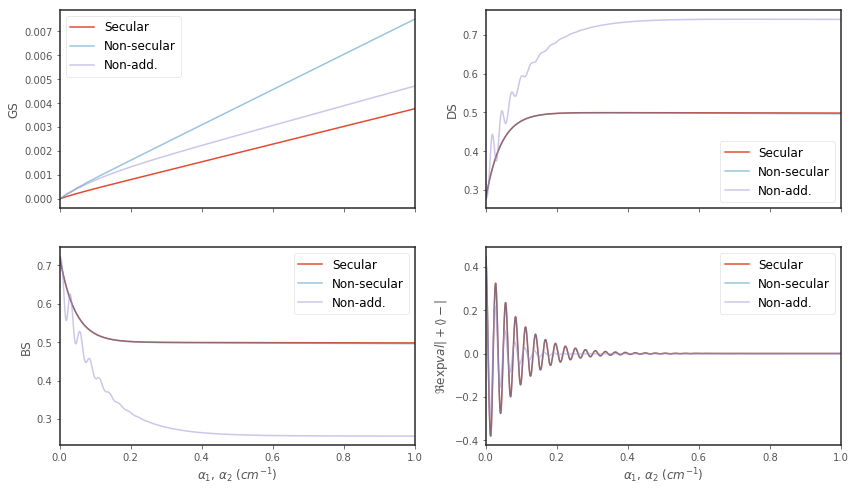

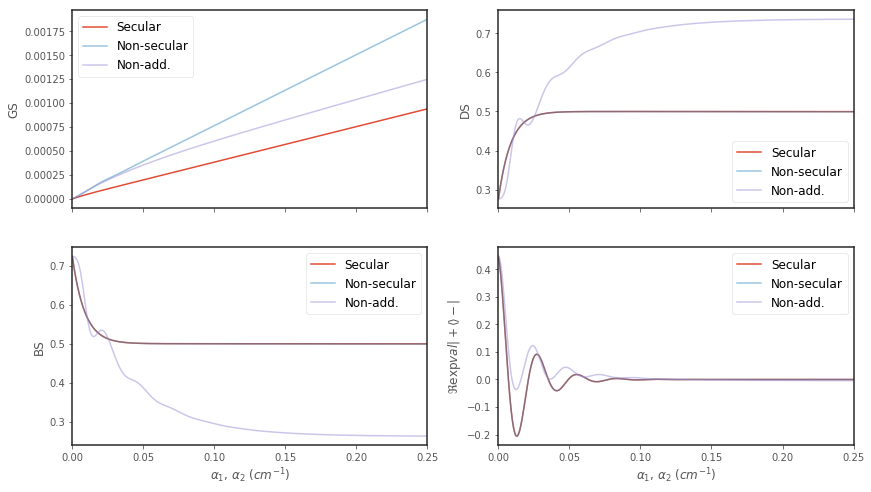

In [45]:
#plot_dynamics(dynamics_4a)
plot_dynamics(dynamics_4b)
plot_dynamics(dynamics_4c)

# Steadystates as a function of coupling strength

In [46]:
def calculate_RWA_steadystate_comparison(PARAMS, phonons, num, threshold=0.):
    ti =time.time()
    rho_add = []
    rho_nonadd = []
    rho_wc = []
    rho_wcs = []
    
    for j, alpha in enumerate(phonons):
        if alpha>30:
            N = 6
        PARAMS.update({'alpha_1':alpha, 'alpha_2': alpha})
        #energies, states = exciton_states(PARAMS)
        H_wc, L_ns, L_s = get_H_and_L_wc(PARAMS['H_sub'], PARAMS)
        H, L, L_add, PARAMS = get_H_and_L(PARAMS, silent=False, threshold=threshold)
        rho_add.append(steadystate(H[1], [L_add]))
        rho_nonadd.append(steadystate(H[1], [L]))
        
        rho_wc.append(steadystate(PARAMS['H_sub'], [L_ns]))
        rho_wcs.append(steadystate(PARAMS['H_sub'], [L_s]))
        if j in [1,10,20,30,40,49]:
            print( alpha)
        #print ss.diag()
    save_obj([rho_nonadd, rho_add, rho_wc, rho_wcs, PARAMS], 'DATA/SES_validity_ss/3ls_{}'.format(num))
    print ('Calculation complete in {} seconds'.format(time.time() - ti))
    return rho_nonadd, rho_add, rho_wc, rho_wcs, PARAMS

def calculate_expval(rho_list, op_list, obs='OO'):
    return [(op_list[i][obs]*rho).tr() for i, rho in enumerate(rho_list)]

In [47]:
T_ph = 300.
w_2 = 1000. #1.4*ev_to_inv_cm
bias = 50. #0.01*ev_to_inv_cm #0.0000001*ev_to_inv_cm
V = 50. #0.01*ev_to_inv_cm #0.00001*ev_to_inv_cm
alpha = 50.
alpha_EM = 5.309e-3 # inv_ps_to_inv_cm *10^-3
N =5
#wc = 50.
w_0 = 500.
Gamma = 2*w_0

phonons = np.linspace(0.5, 50, 50)

rho_s = []
rho_wc = []
rho_add = []
ops_list = []
for alpha in phonons:
    if alpha>30:
        N=6
    PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                          V = V, alpha=alpha,
                          T_EM=6000., T_ph =T_ph, alpha_EM=alpha_EM, shift=True,
                          num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                          silent=True, exc_diff=0)
    #energies, states = exciton_states(PARAMS)
    H, L_ns, L_s = get_H_and_L_wc(PARAMS['H_sub'], PARAMS)
    Hs, L_full, L_add, PARAMS = get_H_and_L(PARAMS, silent=True, threshold=0.)
    #eig_x = states[0]*states[1].dag()+states[1]*states[0].dag()
    #dark = states[0]*states[0].dag()
    #print PARAMS.keys()
    #L = wp.L_weak_phonon_SES(PARAMS)
    rho_s.append(steadystate(Hs[1], [L_full]))
    rho_add.append(steadystate(Hs[1], [L_add]))
    rho_wc.append(steadystate(H, [L_ns]))
    ops_list.append(make_expectation_operators(PARAMS))
    #print ss.diag()
print 'Calculation complete'

SyntaxError: Missing parentheses in call to 'print'. Did you mean print('Calculation complete')? (<ipython-input-47-7655cc9f8134>, line 38)

In [ ]:

        

f, ((ax1, ax2),(ax3, ax4))  = plt.subplots(2, 2, sharex=True, figsize=(12,6))

ax1.plot(phonons, calculate_expval(rho_s, ops_list, obs='OO'), label='non-add.')
ax1.plot(phonons, calculate_expval(rho_add, ops_list, obs='OO'), label='add.')
ax1.plot(phonons, [(r*OO_proj).tr() for r in rho_wc][1:-1], label='Redfield')
#plt.xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
ax1.set_ylabel(r"GS")
ax1.set_xlim(phonons[0], phonons[-1])
ax1.legend()

ax2.plot(phonons, calculate_expval(rho_s, ops_list, obs='dark'), label='non-add.')
ax2.plot(phonons, calculate_expval(rho_add, ops_list, obs='dark'), label='add.')
ax2.plot(phonons, [(r*dark).tr() for r in rho_wc][1:-1], label='Redfield')
#plt.xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
ax2.set_ylabel(r"DS")
ax2.set_xlim(phonons[0], phonons[-1])
ax2.legend()


ax3.plot(phonons, calculate_expval(rho_s, ops_list, obs='bright'), label='non-add.')
ax3.plot(phonons, calculate_expval(rho_add, ops_list, obs='bright'), label='add.')
ax3.plot(phonons, [(r*bright).tr() for r in rho_wc], label='Redfield')
#plt.xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
ax3.set_ylabel(r"BS")
ax3.set_xlim(phonons[0], phonons[-1])
ax3.legend()

ax4.plot(phonons, calculate_expval(rho_s, ops_list, obs='eig_x'), label='non-add.')
ax4.plot(phonons, calculate_expval(rho_add, ops_list, obs='eig_x'), label='add.')
ax4.plot(phonons, [(r*eig_x).tr() for r in rho_wc], label='Redfield')
#plt.xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
ax4.set_ylabel(r"$\langle +|\rho|-\rangle$")
ax4.set_xlim(phonons[0], phonons[-1])
ax4.legend()
plt.show()

#plt.savefig("PLOTS/Redfield-CC.pdf")

In [13]:
w_0 = 100.
Gamma = w_0
phonons = np.linspace(0.5, 50, 49)

rho_s = []
rho_wc = []
rho_sadd = []
ops_list = []
N = 7
for alpha in phonons:
    PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                          V = V, alpha=alpha,
                          T_EM=4000., T_ph =T_ph, alpha_EM=alpha_EM, shift=True,
                          num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                          silent=True, exc_diff=0)
    #energies, states = exciton_states(PARAMS)
    H, L_ns, L_s = get_H_and_L_wc(PARAMS['H_sub'], PARAMS)
    Hs, L_full, L_add, PARAMS = get_H_and_L(PARAMS, silent=True, threshold=0.)
    
    rho_s.append(steadystate(Hs[1], [L_full]))
    rho_add.append(steadystate(Hs[1], [L_add]))
    rho_wc.append(steadystate(H, [L_ns]))
    #print ss.diag()
    ops_list.append(make_expectation_operators(PARAMS))
print 'Calculation complete'


evals, evecs = exciton_states(PARAMS, shift=False)
dark, bright = evecs[0]*evecs[0].dag(), evecs[1]*evecs[1].dag()
eig_x = (evecs[0]*evecs[1].dag() + evecs[1]*evecs[0].dag())*0.5
ops = make_expectation_operators(PARAMS)
site_x = (site_coherence+site_coherence.dag())

It took 0.00977206230164 seconds to build the phenomenological Liouvillian
Non-secular and secular dissipators calculated in 0.830000162125 seconds
It took 0.0202960968018 seconds to build the phenomenological Liouvillian
Non-secular and secular dissipators calculated in 1.26323008537 seconds
It took 0.0285980701447 seconds to build the phenomenological Liouvillian
Non-secular and secular dissipators calculated in 1.80088996887 seconds
It took 0.009761095047 seconds to build the phenomenological Liouvillian
Non-secular and secular dissipators calculated in 0.941185951233 seconds
It took 0.00983786582947 seconds to build the phenomenological Liouvillian
Non-secular and secular dissipators calculated in 0.991052865982 seconds
It took 0.00945091247559 seconds to build the phenomenological Liouvillian
Non-secular and secular dissipators calculated in 1.11189889908 seconds
It took 0.00943899154663 seconds to build the phenomenological Liouvillian
Non-secular and secular dissipators calculat

TypeError: Incompatible Qobj shapes

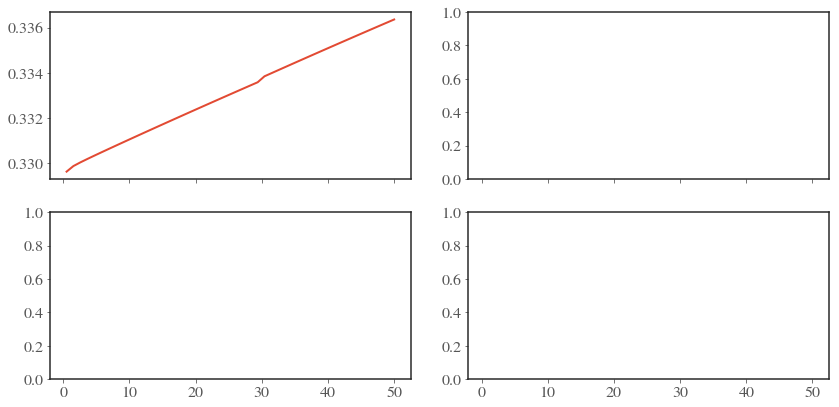

In [14]:
def calculate_expval(rho_list, op_list, obs='OO'):
    return [(op_list[i][obs]*rho).tr() for i, rho in enumerate(rho_list)]
        

f, ((ax1, ax2),(ax3, ax4))  = plt.subplots(2, 2, sharex=True, figsize=(12,6))

ax1.plot(phonons, calculate_expval(rho_s, ops_list, obs='OO'), label='non-add.')
ax1.plot(phonons, calculate_expval(rho_add, ops_list, obs='OO'), label='add.')
ax1.plot(phonons, [(r*OO_proj).tr() for r in rho_wc], label='Redfield')
#plt.xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
ax1.set_ylabel(r"GS")
ax1.set_xlim(phonons[0], phonons[-1])
ax1.legend()

ax2.plot(phonons, calculate_expval(rho_s, ops_list, obs='dark'), label='non-add.')
ax2.plot(phonons, calculate_expval(rho_add, ops_list, obs='dark'), label='add.')
ax2.plot(phonons, [(r*dark).tr() for r in rho_wc], label='Redfield')
#plt.xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
ax2.set_ylabel(r"DS")
ax2.set_xlim(phonons[0], phonons[-1])
ax2.legend()


ax3.plot(phonons, calculate_expval(rho_s, ops_list, obs='bright'), label='non-add.')
ax3.plot(phonons, calculate_expval(rho_add, ops_list, obs='bright'), label='add.')
ax3.plot(phonons, [(r*bright).tr() for r in rho_wc], label='Redfield')
#plt.xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
ax3.set_ylabel(r"BS")
ax3.set_xlim(phonons[0], phonons[-1])
ax3.legend()

ax4.plot(phonons, calculate_expval(rho_s, ops_list, obs='eig_x'), label='non-add.')
ax4.plot(phonons, calculate_expval(rho_add, ops_list, obs='eig_x'), label='add.')
ax4.plot(phonons, [(r*eig_x).tr() for r in rho_wc], label='Redfield')
#plt.xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
ax4.set_ylabel(r"$\langle +|\rho|-\rangle$")
ax4.set_xlim(phonons[0], phonons[-1])
ax4.legend()
plt.show()

In [30]:
w_0 = 125.
Gamma = 2*w_0
phonons = np.linspace(0., 50, 50)

rho_s = []
rho_wc = []
rho_sadd = []

for alpha in phonons:
    PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                          V = V, alpha=alpha,
                          T_EM=6000., T_ph =T_ph, alpha_EM=alpha_EM, shift=True,
                          num_cpus=4, N=5, Gamma=Gamma, w_0=w_0,
                          silent=True, exc_diff=0)
    #energies, states = exciton_states(PARAMS)
    H, L_ns, L_s  = get_H_and_L_wc(PARAMS['H_sub'], PARAMS)
    Hs, Ls, Ladd, PARAMS = get_H_and_L(PARAMS, silent=True, threshold=0.)
    rho_s.append(steadystate(Hs[1], [-Ls]))
    rho_sadd.append(steadystate(Hs[1], [-Ladd]))
    rho_wc.append(steadystate(PARAMS['H_sub'], [L_ns]))
    
    #print ss.diag()
print 'Calculation complete'

It took 0.0130219459534 seconds to build the phenomenological Liouvillian
Non-secular and secular dissipators calculated
It took 0.0350728034973 seconds to build the phenomenological Liouvillian
Non-secular and secular dissipators calculated
It took 0.0259671211243 seconds to build the phenomenological Liouvillian
Non-secular and secular dissipators calculated
It took 0.0190758705139 seconds to build the phenomenological Liouvillian
Non-secular and secular dissipators calculated
It took 0.00964999198914 seconds to build the phenomenological Liouvillian
Non-secular and secular dissipators calculated
It took 0.0427241325378 seconds to build the phenomenological Liouvillian
Non-secular and secular dissipators calculated
It took 0.00985193252563 seconds to build the phenomenological Liouvillian
Non-secular and secular dissipators calculated
It took 0.0100572109222 seconds to build the phenomenological Liouvillian
Non-secular and secular dissipators calculated
It took 0.0112709999084 second

In [34]:
#phonons = phonons[1:-1]
#rho_s = rho_s[1:-1]
rho_sadd = rho_sadd[1:-1]
#rho_wc = rho_wc[1:-1]

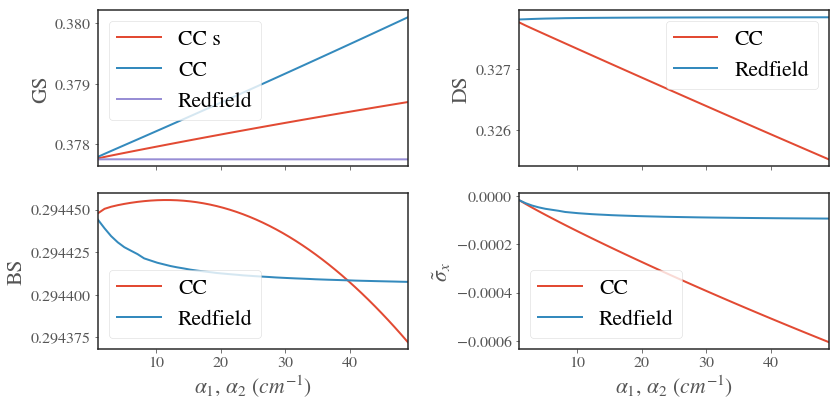

In [35]:
f, ((ax1, ax2),(ax3, ax4))  = plt.subplots(2, 2, sharex=True, figsize=(12,6))

ax1.plot(phonons, [(r*ops['OO']).tr() for r in rho_sadd], label='CC s')
ax1.plot(phonons, [(r*ops['OO']).tr() for r in rho_s], label='CC')
ax1.plot(phonons, [(r*OO_proj).tr() for r in rho_wc], label='Redfield')
#plt.xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
ax1.set_ylabel(r"GS")
ax1.set_xlim(phonons[0], phonons[-1])
ax1.legend()

ax2.plot(phonons, [(r*ops['dark']).tr() for r in rho_s], label='CC')
ax2.plot(phonons, [(r*ops['dark']).tr() for r in rho_s], label='CC')
ax2.plot(phonons, [(r*dark).tr() for r in rho_wc], label='Redfield')
#ax2.set_xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
ax2.set_ylabel(r"DS")
ax2.legend()


ax3.plot(phonons, [(r*ops['bright']).tr() for r in rho_s], label='CC')
ax3.plot(phonons, [(r*bright).tr() for r in rho_wc], label='Redfield')
ax3.set_xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
ax3.set_ylabel(r"BS")
ax3.legend()


ax4.plot(phonons, [(r*ops['eig_x']).tr() for r in rho_s], label='CC')
ax4.plot(phonons, [(r*eig_x).tr() for r in rho_wc], label='Redfield')
ax4.set_xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
ax4.set_ylabel(r"$\tilde{\sigma}_x$")
ax4.legend()
plt.show()

In [36]:
w_0 = 125.
Gamma = 2*w_0
phonons = np.linspace(0., 50, 50)

rho_s = []
rho_wc = []
rho_sadd = []

for alpha in phonons:
    PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                          V = V, alpha=alpha,
                          T_EM=6000., T_ph =T_ph, alpha_EM=alpha_EM, shift=True,
                          num_cpus=4, N=6, Gamma=Gamma, w_0=w_0,
                          silent=True, exc_diff=0)
    #energies, states = exciton_states(PARAMS)
    H, L_ns, L_s  = get_H_and_L_wc(PARAMS['H_sub'], PARAMS)
    Hs, Ls, Ladd, PARAMS = get_H_and_L(PARAMS, silent=True, threshold=0.)
    rho_s.append(steadystate(Hs[1], [-Ls]))
    rho_sadd.append(steadystate(Hs[1], [-Ladd]))
    rho_wc.append(steadystate(PARAMS['H_sub'], [L_ns]))
    
    #print ss.diag()
print 'Calculation complete'

It took 0.013603925705 seconds to build the phenomenological Liouvillian
Non-secular and secular dissipators calculated
It took 0.00960493087769 seconds to build the phenomenological Liouvillian
Non-secular and secular dissipators calculated
It took 0.0100479125977 seconds to build the phenomenological Liouvillian
Non-secular and secular dissipators calculated
It took 0.0098819732666 seconds to build the phenomenological Liouvillian
Non-secular and secular dissipators calculated
It took 0.0100710391998 seconds to build the phenomenological Liouvillian
Non-secular and secular dissipators calculated
It took 0.00977993011475 seconds to build the phenomenological Liouvillian
Non-secular and secular dissipators calculated
It took 0.0100820064545 seconds to build the phenomenological Liouvillian
Non-secular and secular dissipators calculated
It took 0.0100860595703 seconds to build the phenomenological Liouvillian
Non-secular and secular dissipators calculated
It took 0.0097291469574 seconds

In [45]:
ops = make_expectation_operators(PARAMS)

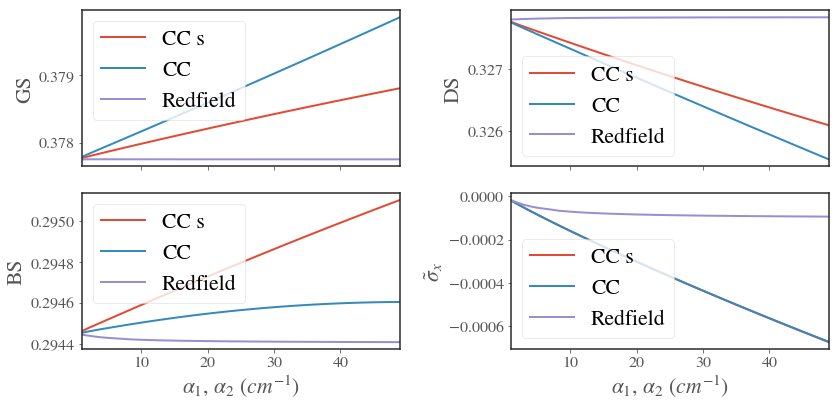

In [51]:
f, ((ax1, ax2),(ax3, ax4))  = plt.subplots(2, 2, sharex=True, figsize=(12,6))

ax1.plot(phonons, [(r*ops['OO']).tr() for r in rho_sadd], label='CC s')
ax1.plot(phonons, [(r*ops['OO']).tr() for r in rho_s], label='CC')
ax1.plot(phonons, [(r*OO_proj).tr() for r in rho_wc], label='Redfield')
#plt.xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
ax1.set_ylabel(r"GS")
ax1.set_xlim(phonons[0], phonons[-1])
ax1.legend()

ax2.plot(phonons, [(r*ops['dark']).tr() for r in rho_sadd], label='CC s')
ax2.plot(phonons, [(r*ops['dark']).tr() for r in rho_s], label='CC')
ax2.plot(phonons, [(r*dark).tr() for r in rho_wc], label='Redfield')
#ax2.set_xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
ax2.set_ylabel(r"DS")
ax2.legend()

ax3.plot(phonons, [(r*ops['bright']).tr() for r in rho_sadd], label='CC s')
ax3.plot(phonons, [(r*ops['bright']).tr() for r in rho_s], label='CC')
ax3.plot(phonons, [(r*bright).tr() for r in rho_wc], label='Redfield')
ax3.set_xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
ax3.set_ylabel(r"BS")
ax3.legend()


ax4.plot(phonons, [(r*ops['eig_x']).tr() for r in rho_sadd], label='CC s')
ax4.plot(phonons, [(r*ops['eig_x']).tr() for r in rho_s], label='CC')
ax4.plot(phonons, [(r*eig_x).tr() for r in rho_wc], label='Redfield')
ax4.set_xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
ax4.set_ylabel(r"$\tilde{\sigma}_x$")
ax4.legend()
plt.show()

In [54]:
w_0 = 75.
Gamma = 2*w_0
phonons = np.linspace(1, 50, 49)

rho_s = []
rho_wc = []
rho_sadd = []

for alpha in phonons:
    PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                          V = V, alpha=alpha,
                          T_EM=6000., T_ph =T_ph, alpha_EM=alpha_EM, shift=True,
                          num_cpus=4, N=7, Gamma=Gamma, w_0=w_0,
                          silent=True, exc_diff=0)
    #energies, states = exciton_states(PARAMS)
    H, L_ns, L_s  = get_H_and_L_wc(PARAMS['H_sub'], PARAMS)
    Hs, Ls, Ladd, PARAMS = get_H_and_L(PARAMS, silent=True, threshold=0.)
    rho_s.append(steadystate(Hs[1], [-Ls]))
    rho_sadd.append(steadystate(Hs[1], [-Ladd]))
    rho_wc.append(steadystate(PARAMS['H_sub'], [L_ns]))
    
    #print ss.diag()
print 'Calculation complete'

It took 0.0140907764435 seconds to build the phenomenological Liouvillian
Non-secular and secular dissipators calculated
It took 0.0204060077667 seconds to build the phenomenological Liouvillian
Non-secular and secular dissipators calculated
It took 0.0101909637451 seconds to build the phenomenological Liouvillian
Non-secular and secular dissipators calculated
It took 0.00996804237366 seconds to build the phenomenological Liouvillian
Non-secular and secular dissipators calculated
It took 0.00993299484253 seconds to build the phenomenological Liouvillian
Non-secular and secular dissipators calculated
It took 0.00960803031921 seconds to build the phenomenological Liouvillian
Non-secular and secular dissipators calculated
It took 0.00965714454651 seconds to build the phenomenological Liouvillian
Non-secular and secular dissipators calculated
It took 0.00998497009277 seconds to build the phenomenological Liouvillian
Non-secular and secular dissipators calculated
It took 0.00996804237366 se

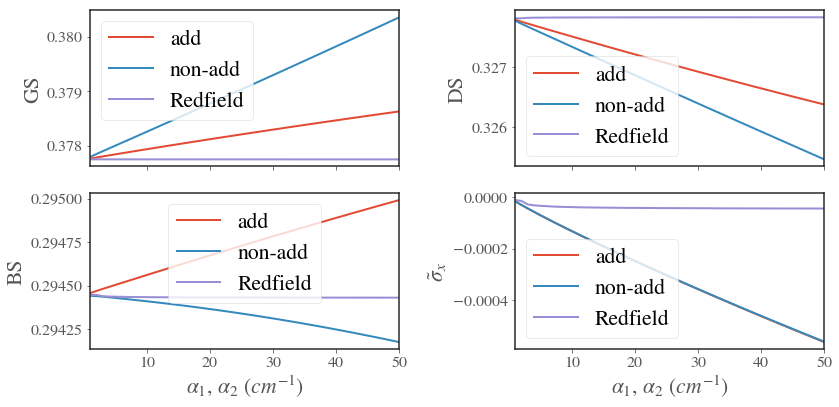

In [57]:
ops = make_expectation_operators(PARAMS)

f, ((ax1, ax2),(ax3, ax4))  = plt.subplots(2, 2, sharex=True, figsize=(12,6))

ax1.plot(phonons, [(r*ops['OO']).tr() for r in rho_sadd], label='add')
ax1.plot(phonons, [(r*ops['OO']).tr() for r in rho_s], label='non-add')
ax1.plot(phonons, [(r*OO_proj).tr() for r in rho_wc], label='Redfield')
#plt.xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
ax1.set_ylabel(r"GS")
ax1.set_xlim(phonons[0], phonons[-1])
ax1.legend()

ax2.plot(phonons, [(r*ops['dark']).tr() for r in rho_sadd], label='add')
ax2.plot(phonons, [(r*ops['dark']).tr() for r in rho_s], label='non-add')
ax2.plot(phonons, [(r*dark).tr() for r in rho_wc], label='Redfield')
#ax2.set_xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
ax2.set_ylabel(r"DS")
ax2.legend()

ax3.plot(phonons, [(r*ops['bright']).tr() for r in rho_sadd], label='add')
ax3.plot(phonons, [(r*ops['bright']).tr() for r in rho_s], label='non-add')
ax3.plot(phonons, [(r*bright).tr() for r in rho_wc], label='Redfield')
ax3.set_xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
ax3.set_ylabel(r"BS")
ax3.legend()


ax4.plot(phonons, [(r*ops['eig_x']).tr() for r in rho_sadd], label='add')
ax4.plot(phonons, [(r*ops['eig_x']).tr() for r in rho_s], label='non-add')
ax4.plot(phonons, [(r*eig_x).tr() for r in rho_wc], label='Redfield')
ax4.set_xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
ax4.set_ylabel(r"$\tilde{\sigma}_x$")
ax4.legend()
plt.show()

Qualitative behaviour change for very low RC frequency in the non-additive theory. Again, the exciton coherence is unaffected by additivity. Would need to check convergence here, since the BS has a tendency of breaking.

In [58]:
w_0 = 125.
Gamma = 2*w_0
phonons = np.linspace(0.5, 50, 30)

rho_s = []
rho_wc = []
rho_sadd = []

for alpha in phonons:
    PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                          V = V, alpha=alpha,
                          T_EM=6000., T_ph =77., alpha_EM=alpha_EM, shift=True,
                          num_cpus=4, N=6, Gamma=Gamma, w_0=w_0,
                          silent=True, exc_diff=0)
    #energies, states = exciton_states(PARAMS)
    H, L_ns, L_s  = get_H_and_L_wc(PARAMS['H_sub'], PARAMS)
    Hs, Ls, Ladd, PARAMS = get_H_and_L(PARAMS, silent=True, threshold=0.)
    rho_s.append(steadystate(Hs[1], [-Ls]))
    rho_sadd.append(steadystate(Hs[1], [-Ladd]))
    rho_wc.append(steadystate(PARAMS['H_sub'], [L_ns]))
    
    #print ss.diag()
print 'Calculation complete'

It took 0.0185971260071 seconds to build the phenomenological Liouvillian
Non-secular and secular dissipators calculated
It took 0.0232439041138 seconds to build the phenomenological Liouvillian
Non-secular and secular dissipators calculated
It took 0.0195069313049 seconds to build the phenomenological Liouvillian
Non-secular and secular dissipators calculated
It took 0.0139260292053 seconds to build the phenomenological Liouvillian
Non-secular and secular dissipators calculated
It took 0.00982308387756 seconds to build the phenomenological Liouvillian
Non-secular and secular dissipators calculated
It took 0.00997710227966 seconds to build the phenomenological Liouvillian
Non-secular and secular dissipators calculated
It took 0.0224101543427 seconds to build the phenomenological Liouvillian
Non-secular and secular dissipators calculated
It took 0.0101191997528 seconds to build the phenomenological Liouvillian
Non-secular and secular dissipators calculated
It took 0.0100500583649 second

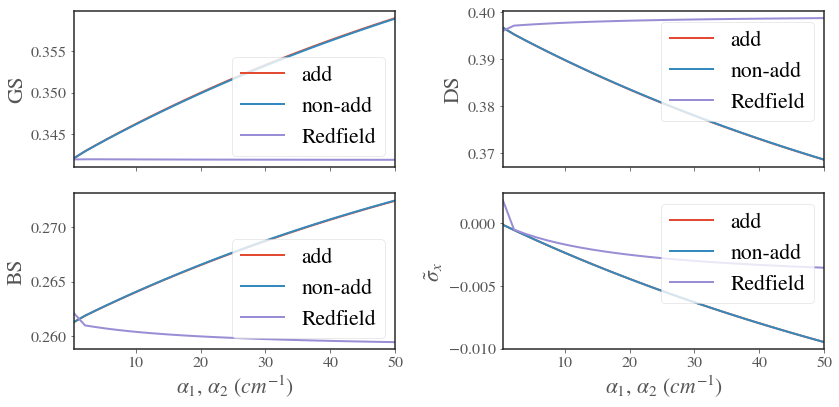

In [59]:
ops = make_expectation_operators(PARAMS)

f, ((ax1, ax2),(ax3, ax4))  = plt.subplots(2, 2, sharex=True, figsize=(12,6))

ax1.plot(phonons, [(r*ops['OO']).tr() for r in rho_sadd], label='add')
ax1.plot(phonons, [(r*ops['OO']).tr() for r in rho_s], label='non-add')
ax1.plot(phonons, [(r*OO_proj).tr() for r in rho_wc], label='Redfield')
#plt.xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
ax1.set_ylabel(r"GS")
ax1.set_xlim(phonons[0], phonons[-1])
ax1.legend()

ax2.plot(phonons, [(r*ops['dark']).tr() for r in rho_sadd], label='add')
ax2.plot(phonons, [(r*ops['dark']).tr() for r in rho_s], label='non-add')
ax2.plot(phonons, [(r*dark).tr() for r in rho_wc], label='Redfield')
#ax2.set_xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
ax2.set_ylabel(r"DS")
ax2.legend()

ax3.plot(phonons, [(r*ops['bright']).tr() for r in rho_sadd], label='add')
ax3.plot(phonons, [(r*ops['bright']).tr() for r in rho_s], label='non-add')
ax3.plot(phonons, [(r*bright).tr() for r in rho_wc], label='Redfield')
ax3.set_xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
ax3.set_ylabel(r"BS")
ax3.legend()


ax4.plot(phonons, [(r*ops['eig_x']).tr() for r in rho_sadd], label='add')
ax4.plot(phonons, [(r*ops['eig_x']).tr() for r in rho_s], label='non-add')
ax4.plot(phonons, [(r*eig_x).tr() for r in rho_wc], label='Redfield')
ax4.set_xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
ax4.set_ylabel(r"$\tilde{\sigma}_x$")
ax4.legend()
plt.show()

Absolutely no difference on this scale when $T_{ph}=77K$